# Digit Recognizer

https://www.kaggle.com/c/digit-recognizer/overview

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Data Loading

In [3]:
from fastai.vision import *

In [4]:
path = Config.data_path()/'digit-recognizer'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/jupyter/.fastai/data/digit-recognizer')

In [5]:
#! pip install kaggle --upgrade

In [6]:
#! rm {path}/*

#! kaggle competitions download -c digit-recognizer -p {path}
#! unzip -q -n {path}/digit-recognizer.zip -d {path}
#! rm {path}/*.zip

#path.ls()

In [7]:
df = pd.read_csv(path/'train.csv', header='infer')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
class NumpyImageList(ImageList):
    def open(self, fn):
        img = fn.reshape(28,28,1)
        return Image(pil2tensor(img, dtype=np.float32))

    @classmethod
    def from_csv(cls, path:PathOrStr, csv:str, **kwargs)->'ItemList': 
        df = pd.read_csv(Path(path)/csv, header='infer')
        res = super().from_df(df, path=path, cols=0, **kwargs)

        if 'label' in df.columns:
            df = df.drop('label', axis=1)
        df = np.array(df)/255.
        mean = df.mean()
        std = df.std()
        res.items = (df-mean)/std
        return res

In [16]:
test = NumpyImageList.from_csv(path, 'test.csv')
tfms = (rand_pad(padding=3, size=28, mode='zeros'), [])
data = (NumpyImageList.from_csv(path, 'train.csv')
        .split_by_rand_pct(.1, seed=42)
        .label_from_df(cols='label')
        .add_test(test, label=0)
        .transform(tfms)
        .databunch(bs=128, num_workers=0)
        .normalize(imagenet_stats))
data

ImageDataBunch;

Train: LabelList (37800 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,1,4,0,7
Path: /home/jupyter/.fastai/data/digit-recognizer;

Valid: LabelList (4200 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
8,1,9,9,8
Path: /home/jupyter/.fastai/data/digit-recognizer;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
0,0,0,0,0
Path: /home/jupyter/.fastai/data/digit-recognizer

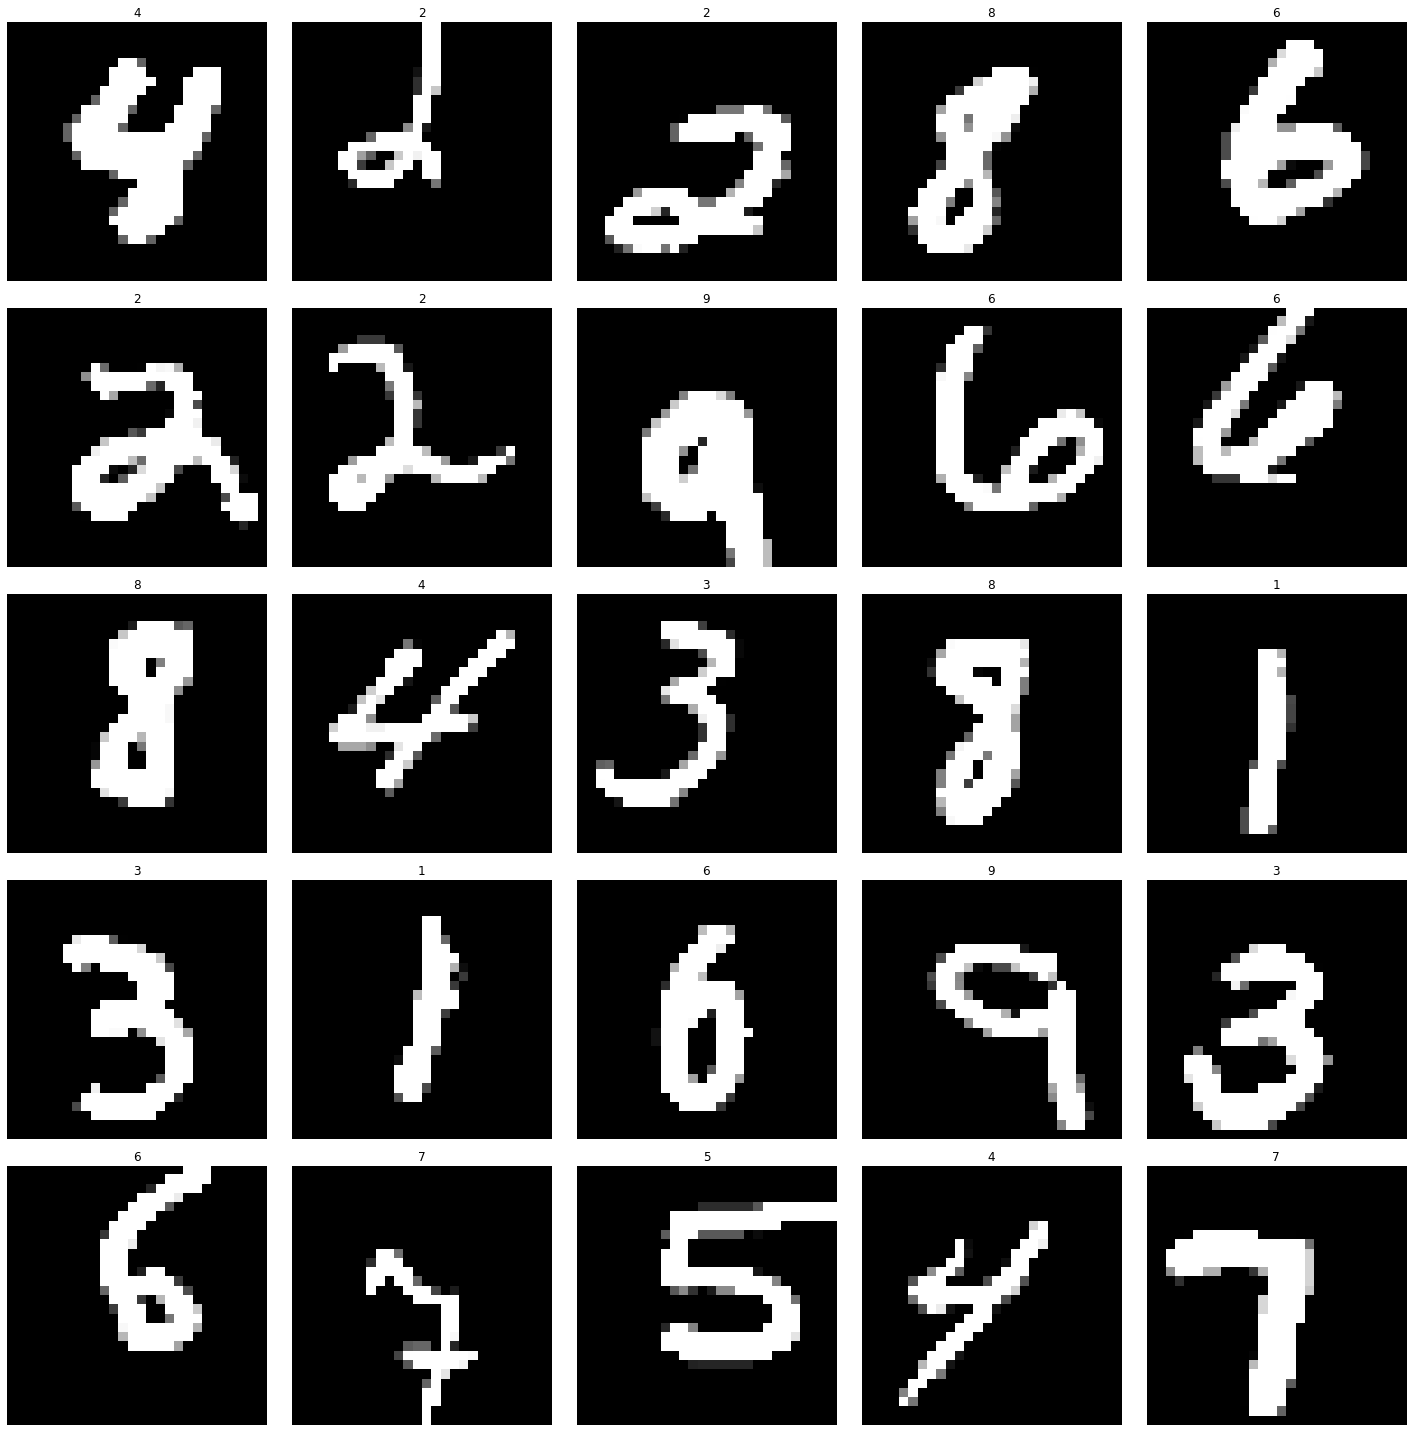

In [14]:
data.show_batch()

# Training

In [28]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-02
Min loss divided by 10: 3.63E-02


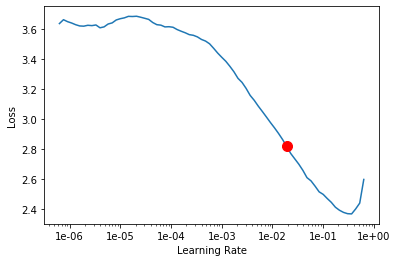

In [30]:
learn.recorder.plot(suggestion=True)

In [31]:
lr = 3e-2
learn.fit_one_cycle(4, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.494062,0.222890,0.064048,00:13
1,0.168378,0.089690,0.028571,00:12
2,0.115452,0.060241,0.020952,00:12
3,0.087881,0.041464,0.014524,00:12


In [32]:
learn.save('tfms2-norms2-stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06
Min loss divided by 10: 1.32E-05


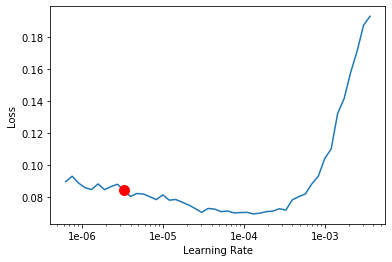

In [36]:
learn.load('tfms2-norms2-stage-1')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [37]:
learn.fit_one_cycle(4, slice(1e-6, 2e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.071957,0.039009,0.013333,00:15
1,0.065949,0.034878,0.011429,00:15
2,0.060350,0.031788,0.011667,00:15
3,0.048346,0.031160,0.012143,00:14


In [38]:
learn.save('tfms2-norms2-stage-2')

## Resnet50

In [49]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-03
Min loss divided by 10: 2.51E-02


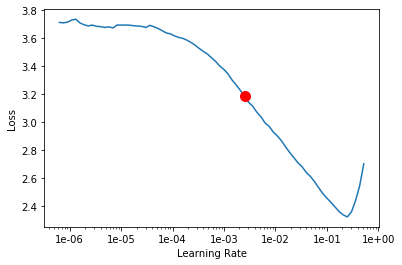

In [50]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [51]:
lr = 2e-2
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.875594,0.479701,0.157143,00:17
1,0.333504,0.195616,0.059762,00:16
2,0.166503,0.123073,0.035714,00:16
3,0.112310,0.066672,0.022381,00:16
4,0.101663,0.045685,0.011667,00:16
5,0.069256,0.031655,0.009286,00:16
6,0.054019,0.030503,0.009048,00:16
7,0.031734,0.023067,0.007381,00:16
8,0.034802,0.024638,0.006667,00:16
9,0.028223,0.023673,0.007143,00:16


In [52]:
learn.save('tfms2-norms2-stage-1-rn50')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.58E-07


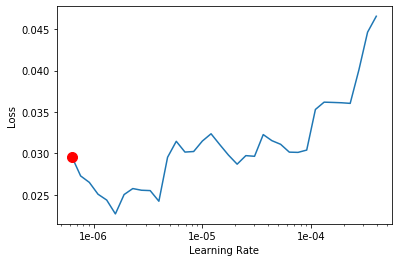

In [58]:
learn.load('tfms2-norms2-stage-1-rn50')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [59]:
learn.fit_one_cycle(10, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.026882,0.022584,0.006429,00:20
1,0.024615,0.024393,0.007143,00:20
2,0.025412,0.021807,0.006667,00:20
3,0.026865,0.020646,0.006905,00:19
4,0.024890,0.021323,0.006429,00:19
5,0.023533,0.020244,0.006190,00:19
6,0.016900,0.021328,0.006905,00:19
7,0.017226,0.020945,0.006429,00:20
8,0.015441,0.021983,0.007381,00:19
9,0.015728,0.020426,0.007381,00:19


In [60]:
learn.save('tfms2-norms2-stage-2-rn50')

## Resnet101

In [68]:
learn = cnn_learner(data, models.resnet101, metrics=[accuracy,error_rate])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02
Min loss divided by 10: 1.20E-02


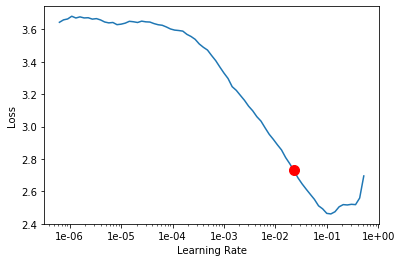

In [69]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [70]:
lr = 1e-2
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.061470,0.655212,0.787619,0.212381,00:26
1,0.415752,0.202356,0.936190,0.063810,00:26
2,0.199790,0.096228,0.972381,0.027619,00:26
3,0.130025,0.067778,0.979524,0.020476,00:26
4,0.103073,0.055313,0.984048,0.015952,00:27
5,0.083251,0.034997,0.990000,0.010000,00:26
6,0.072419,0.027208,0.990714,0.009286,00:26
7,0.057852,0.023375,0.992619,0.007381,00:26
8,0.039197,0.023514,0.992143,0.007857,00:26
9,0.035940,0.022038,0.992619,0.007381,00:27


In [71]:
learn.save('tfms2-norms2-stage-1-rn101')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.51E-06


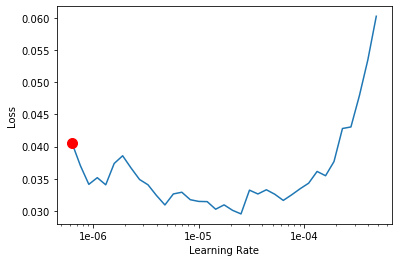

In [75]:
learn.load('tfms2-norms2-stage-1-rn101')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [76]:
learn.fit_one_cycle(10, slice(2e-6, 5e-5))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.037874,0.021840,0.993810,0.006190,00:35
1,0.037839,0.023604,0.992381,0.007619,00:35
2,0.040976,0.020565,0.992857,0.007143,00:35
3,0.033858,0.023461,0.991667,0.008333,00:35
4,0.029834,0.021126,0.993333,0.006667,00:36
5,0.028762,0.020724,0.992381,0.007619,00:35
6,0.019530,0.017766,0.993810,0.006190,00:35
7,0.021187,0.017337,0.994048,0.005952,00:35
8,0.017660,0.018146,0.993571,0.006429,00:35
9,0.016134,0.016571,0.993333,0.006667,00:36


In [77]:
learn.save('tfms2-norms2-stage-2-rn101')

# Test

In [78]:
learn.load('tfms2-norms2-stage-2-rn101')

Learner(data=ImageDataBunch;

Train: LabelList (37800 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,1,4,0,7
Path: /home/jupyter/.fastai/data/digit-recognizer;

Valid: LabelList (4200 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
8,1,9,9,8
Path: /home/jupyter/.fastai/data/digit-recognizer;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
0,0,0,0,0
Path: /home/jupyter/.fastai/data/digit-recognizer, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False

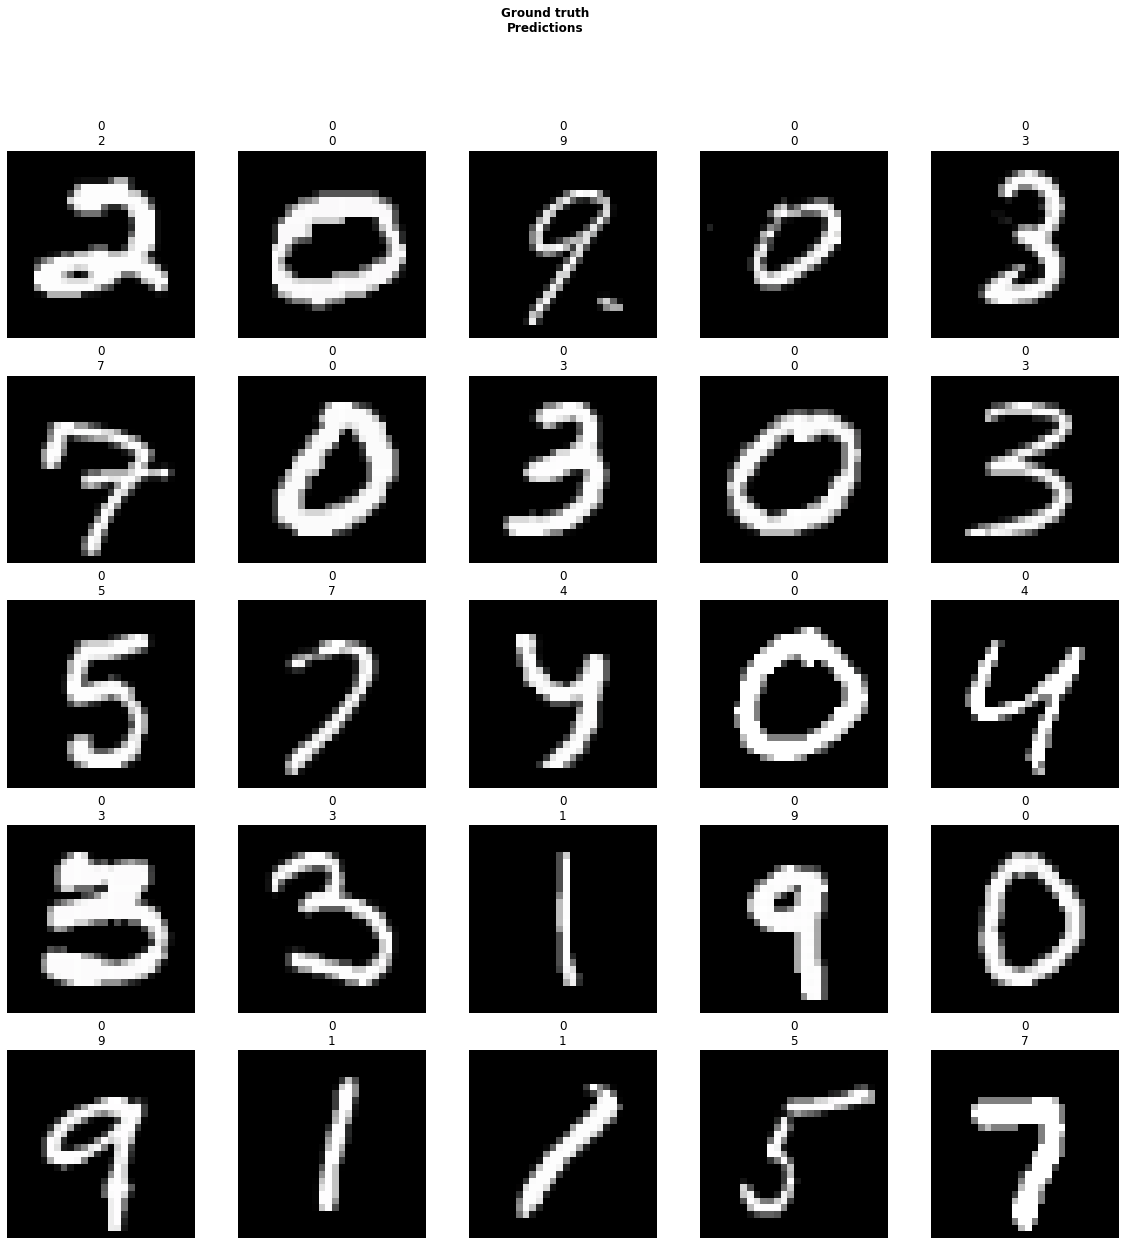

In [79]:
learn.show_results(ds_type=DatasetType.Test)

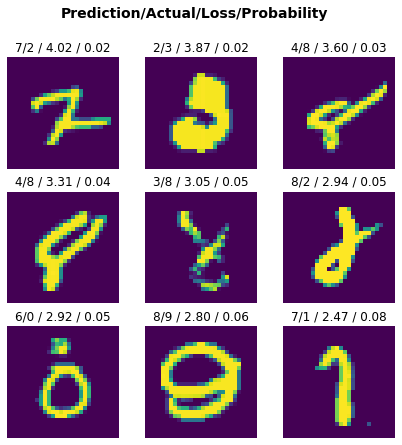

In [80]:
interp = learn.interpret()
interp.plot_top_losses(9, figsize=(7,7))

# Submit to Kaggle

In [81]:
pred_test = learn.get_preds(ds_type=DatasetType.Test)

In [82]:
test_result = torch.argmax(pred_test[0],dim=1).numpy()
test_result, len(test_result)

(array([2, 0, 9, 0, ..., 7, 3, 9, 2]), 28000)

In [84]:
pd_result = pd.Series(test_result,name='Label')
submission = pd.concat([pd.Series(range(1,28001),name='ImageId'),pd_result],axis=1)

submission_path = path/'submit-tfms2-norms2-stage-2-rn101.csv'
submission.to_csv(submission_path,index=False)
submission_message = 'Submission generated with a pretrained Resnet101 model and the fastai library.'

In [86]:
!kaggle competitions submit -c digit-recognizer -f {submission_path} -m '{submission_message}'

100%|████████████████████████████████████████| 208k/208k [00:03<00:00, 67.9kB/s]
Successfully submitted to Digit Recognizer